In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from utils_detection import load_data, save_file, load_file, VehicleDetection, get_hog_features, find_cars
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

# Load Data

In [2]:
dir_vehicle='./data/vehicles/**'
dir_nonvehicle='./data/non-vehicles/**'
color_space="YCrCb"
spatial_feat=True
hist_feat=True
hog_feat=True
hog_channel="ALL"

X, y = load_data(dir_vehicle=dir_vehicle, dir_nonvehicle=dir_nonvehicle, color_space=color_space, 
          spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, hog_channel=hog_channel)

# Split Data into Training and Test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2017)
print ("Training Sets Number: ", len(X_train))
print ("Testing  Sets Number: ", len(X_test))

Training Sets Number:  14208
Testing  Sets Number:  3552


# Using Linear SVM and GridSearch to train the model

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

parameters = {'C':[0.01, 0.1, 1, 10]}
svr = LinearSVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [5]:
print ("Best parameters: ", clf.best_params_)
print ("CV accuracy: ", clf.best_score_)
print ("Test accuracy: ", clf.best_estimator_.score(X_test, y_test))

Best parameters:  {'C': 0.01}
CV accuracy:  0.988105292793
Test accuracy:  0.990427927928


# Retraining SVM using all datasets

In [6]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

clf_final = LinearSVC(C=0.01)
clf_final.fit(X_scale, y)

model = {"scaler":scaler, "clf":clf_final}
#save_file(model, "model.pkl")

# Load Model

In [7]:
model = load_file('model.pkl')
clf_final = model['clf']
scaler = model['scaler']
ystart = 400
ystop = 656
scale = 1.5
orient=9
pix_per_cell=8
cell_per_block=2 
spatial_size=(32, 32)
hist_bins=32

# Test Images

In [8]:
from utils_detection import add_heat, apply_threshold, draw_labeled_bboxes, get_box_img
from scipy.ndimage.measurements import label
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
def single_test(file_img, ax, col_num):
    img = mpimg.imread(file_img)
    # find bounding box
    _, box_list1 = find_cars(img, 400, 656, 1.5, q.clf_final, q.scaler, q.orient, q.pix_per_cell, 
    q.cell_per_block, q.spatial_size, q.hist_bins)
    _, box_list2 = find_cars(img, 400, 500, 0.8, q.clf_final, q.scaler, q.orient, q.pix_per_cell, 
        q.cell_per_block, q.spatial_size, q.hist_bins)
    box_list = box_list1 + box_list2
    # original box plot
    original_box = draw_boxes(img, box_list)
    # using heatmap to delete false positive
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat1 = add_heat(heat,box_list)
    heat2 = apply_threshold(np.copy(heat1), thre)
    heatmap = np.clip(heat2, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    # plot
    plot_array = [img, original_box, heat1, heatmap, labels[0], draw_img]
    for i,k in enumerate(plot_array):
        if i in [2,3]:
            ax[i][col_num].imshow(k, "hot")
        elif i==4:
            ax[i][col_num].imshow(k, "gray")
        else:
            ax[i][col_num].imshow(k)

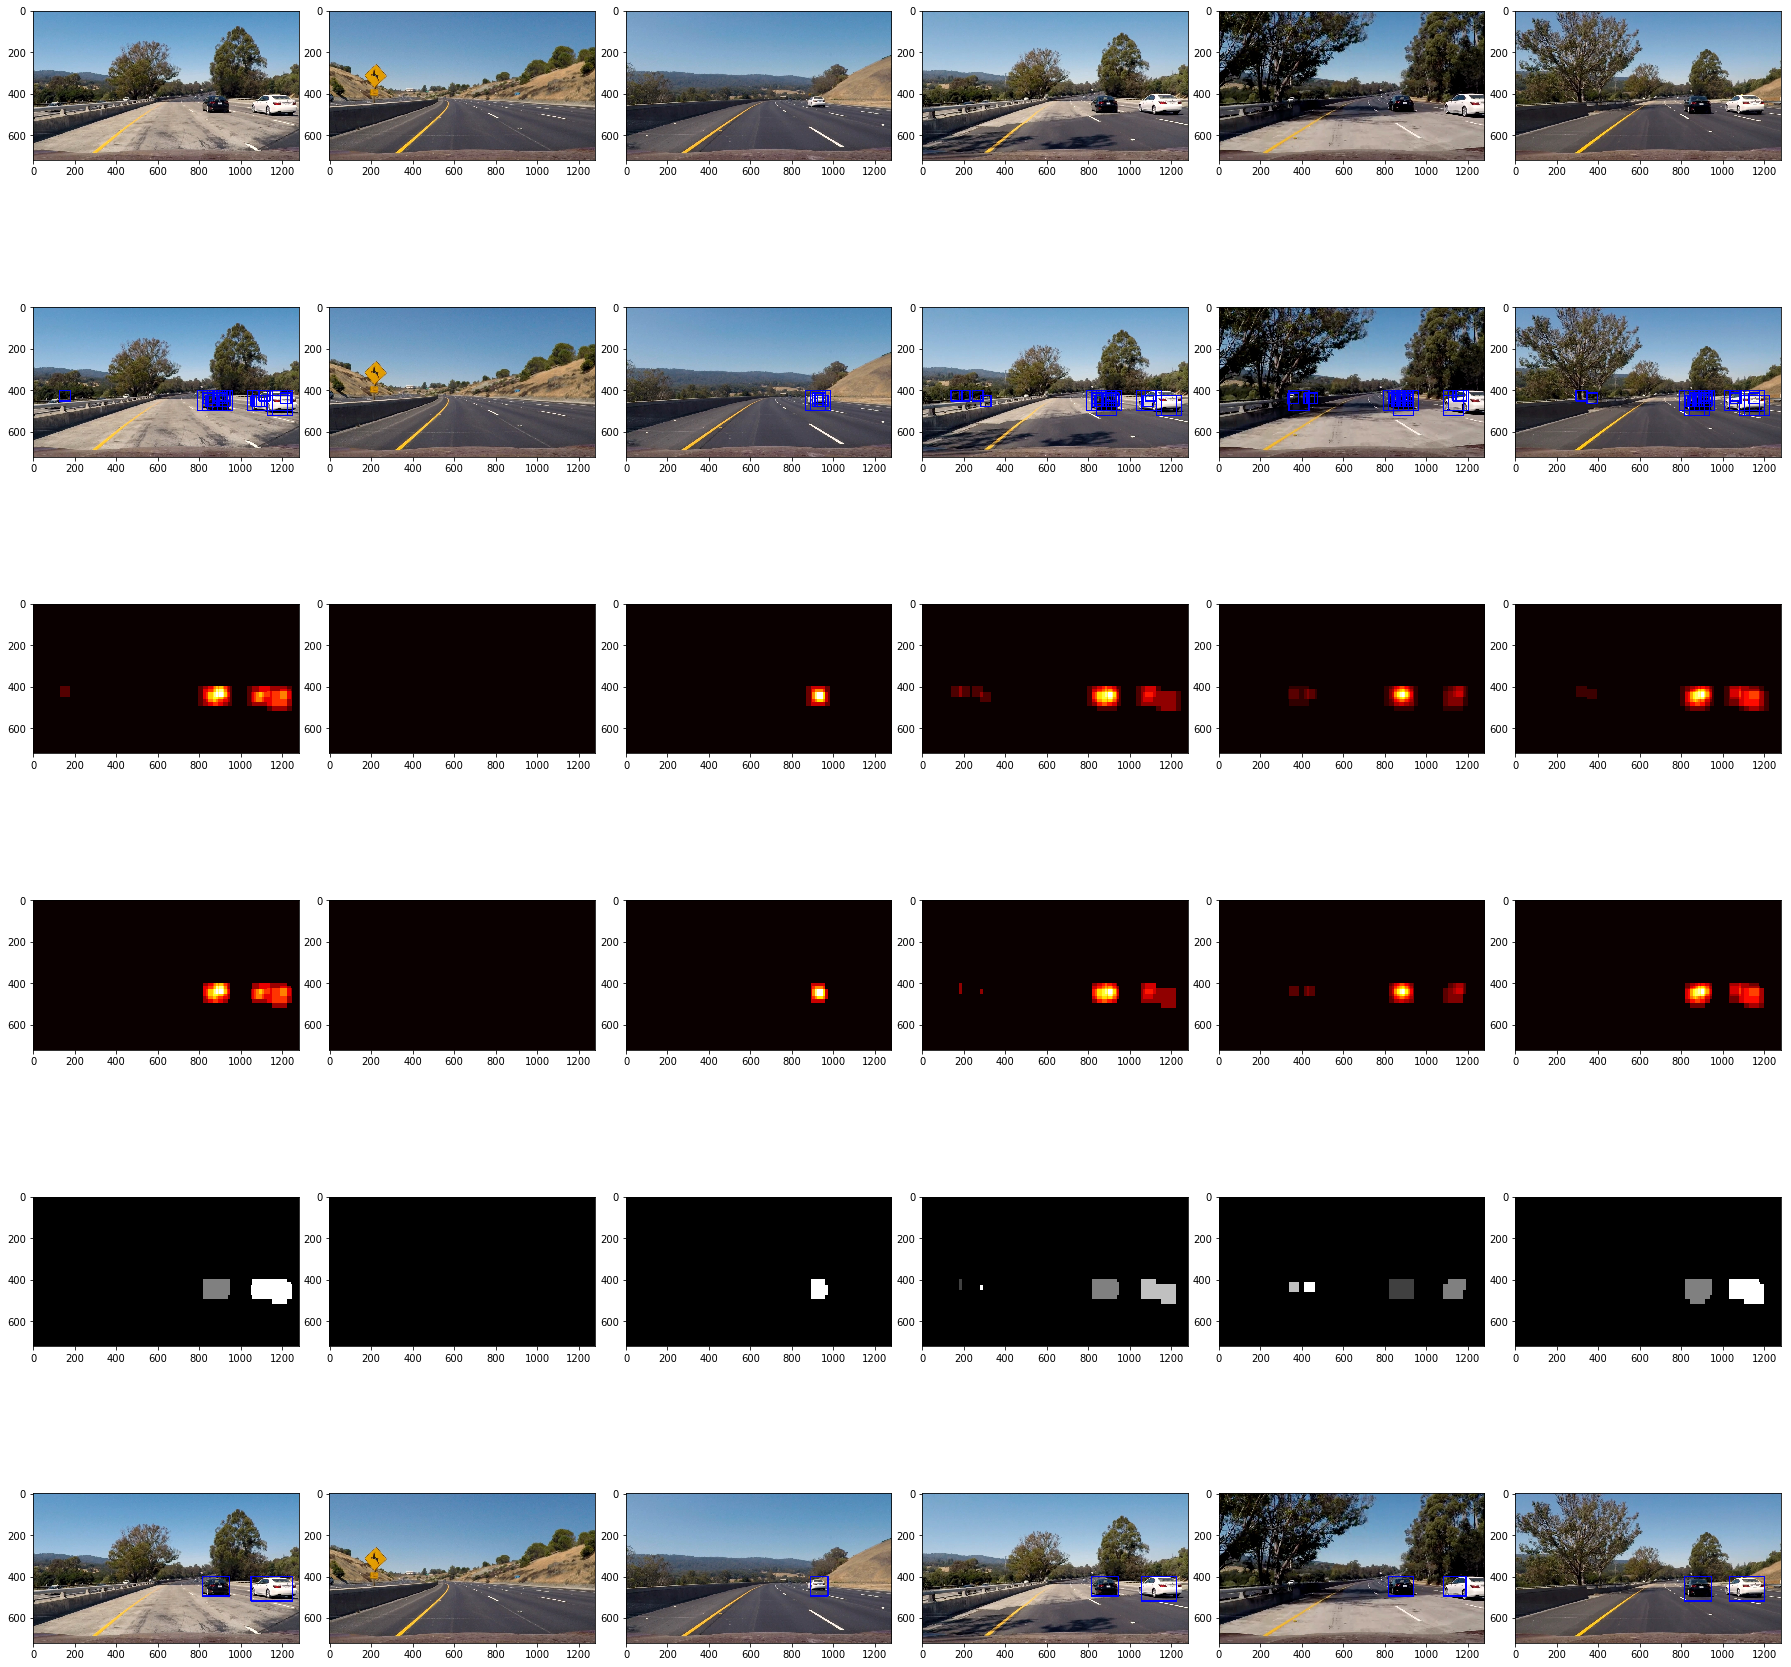

In [9]:
lq = 2
thre = 1
q = VehicleDetection(lq, thre, ystart, ystop, scale, clf_final, scaler,
        orient, pix_per_cell, cell_per_block, 
        spatial_size, hist_bins)

all_files = glob.glob("./test_images/*")
fig, ax = plt.subplots(6,len(all_files), figsize=(25,25))
fig.tight_layout(h_pad=0.1, w_pad=0.01)
for i,k in enumerate(all_files):
    single_test(k, ax, i)

# Video Frame

In [10]:
lq = 25
thre = 10
q = VehicleDetection(lq, thre, ystart, ystop, scale, clf_final, scaler,
        orient, pix_per_cell, cell_per_block, 
        spatial_size, hist_bins)

In [11]:
output = 'project_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(lambda img: q.pipeline(img))
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [18:01<00:00,  1.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 



In [12]:
# output = '35-38-frame-q25t10-filter.mp4'
# clip1 = VideoFileClip("./project_video.mp4").subclip(35,38)
# clip = clip1.fl_image(lambda img: q.pipeline(img))
# clip.write_videofile(output, audio=False)

In [13]:
# output = '27-31-frame-q25t10-filter.mp4'
# clip1 = VideoFileClip("./project_video.mp4").subclip(27,31)
# clip = clip1.fl_image(lambda img: q.pipeline(img))
# clip.write_videofile(output, audio=False)

In [14]:
# output = '40-42-frame-q25t10-filter.mp4'
# clip1 = VideoFileClip("./project_video.mp4").subclip(40,42)
# clip = clip1.fl_image(lambda img: q.pipeline(img))
# clip.write_videofile(output, audio=False)

In [15]:
# output = '9-12-frame-q25t10-filter.mp4'
# clip1 = VideoFileClip("./project_video.mp4").subclip(9,12)
# clip = clip1.fl_image(lambda img: q.pipeline(img))
# clip.write_videofile(output, audio=False)